# Assignment 9: Improving performance

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

In [1]:
%matplotlib inline
%load_ext cython

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 

import cppimport
from numba import jit, vectorize, float64, int64

In [3]:
sns.set_context('notebook', font_scale=1.5)

**Functions to optimize**

In [4]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

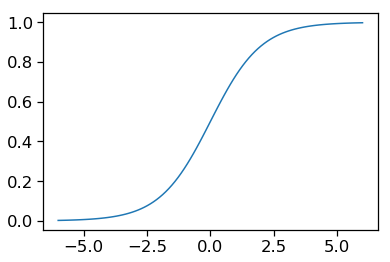

In [5]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [6]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

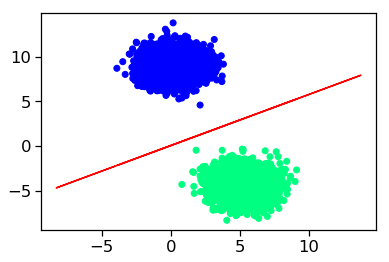

In [7]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

reinitialize x

In [8]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

original logistic function

In [9]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

implement logistic function with one call only

In [10]:
def logistic_onecall(x):
    """Logistic function."""
    return 1/(1 + np.exp(-x))

check to make sure the results are the same

In [11]:
y1 = logistic(x)
y2 = logistic_onecall(x)
np.allclose(y1, y2)

True

measure efficiency

In [12]:
%%timeit
y1 = logistic(x)

529 ms ± 9.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
y2 = logistic_onecall(x)

403 ms ± 4.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

# Q21 
**Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel`**

In [14]:
@vectorize([float64(float64)])
def logistic_numba_cpu(x):
    """Logistic function."""
    return 1 / (1 + np.exp(-x))

In [15]:
@vectorize([float64(float64)], target='parallel')
def logistic_numba_parallel(x):
    """Logistic function."""
    return 1 / (1 + np.exp(-x))

# Q22
**For each function, check that the answers are the same as with the original logistic function using  `np.testing`. Use `%timeit` to compare the three logistic functions (5 points)**

check to make sure the results are the same

In [16]:
y1  = logistic(x)
y2 = logistic_numba_cpu(x)
y3 = logistic_numba_parallel(x)

print(np.allclose(y1, y2))
print(np.allclose(y1, y3))
print(np.testing.assert_allclose(y1, y2))
print(np.testing.assert_allclose(y1, y3))

True
True
None
None


measure efficiency

In [17]:
%%timeit
y1 = logistic(x)

517 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
y2 = logistic_numba_cpu(x)

256 ms ± 5.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
y3 = logistic_numba_parallel(x)

43.2 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Q23 
**Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)**

In [20]:
@jit('double[:](double[:])', nopython = True)
def logistic_numba(x):
    """Logistic function."""
    return 1 / (1 + np.exp(-x))

@jit('double[:](double[:,:], double[:], double[:], double, int32)', nopython = True)
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

# Q24
**Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance.**

In [21]:
y1 = logistic(x)
y2 = logistic_numba(x)
np.allclose(y1, y2)

True

In [22]:
β  = np.zeros(p + 1)
β1 = gd(X, y, β, α, niter)
β2 = gd_numba(X, y, β, α, niter)
print(np.allclose(β1, β2))

True


In [23]:
%%timeit
β1 = gd(X, y, β, α, niter)

1.99 s ± 360 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
β2 = gd_numba(X, y, β, α, niter)

The slowest run took 5.99 times longer than the fastest. This could mean that an intermediate result is being cached.
572 ms ± 575 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate (-a)` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

# Q31
**Cythonize the logistic function as `logistic_cython`. Use the `--annotate (-a)` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version.**

use cython directly without any change

define static type for the variables

In [25]:
%%cython -a
cimport cython
import numpy as np
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def logistic_cython(double[:] x):
    cdef int idx       = 0
    cdef int length    = x.shape[0]
    cdef float tmp
    cdef double[:] res = np.empty(length)
    #res = np.empty(length)
    
    with cython.nogil:
        for idx in range(length):
            tmp = (1.0 + exp(-x[idx]))
            res[idx] = 1.0 / tmp
        
    return res

check if the output are the same

In [26]:
y  = logistic(x)
y1 = logistic_numba_cpu(x)
y2 = logistic_cython(x)

print(np.allclose(y, y1))
print(np.allclose(y, y2))

True
True


measure efficiency

In [27]:
%%timeit
y  = logistic(x)

516 ms ± 6.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
y1 = logistic_numba_cpu(x)

255 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
y2 = logistic_cython(x)

286 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


it turns out the 

# Q32
**Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version.**

In [30]:
%%cython -a
import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef logistic_cython(double[:] x):
    """Logistic function."""
    cdef int idx       = 0
    cdef int length    = x.shape[0]
    cdef double[:] res = np.empty(length)
    
    for idx in range(length):
        res[idx] = 1 / (1 + exp(-x[idx]))
        
    return res

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def gd_cython(double[:,:] X, y, beta, double alpha, int niter):
    """Gradient descent algorihtm."""
    cdef int n = X.shape[0]
    cdef double[:, :] carr_view = X
    
    cdef double[:, :] Xt = carr_view.T
    for i in range(niter):
        y_pred = logistic_cython(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

Test if gd and gd_cython work ok

In [31]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

# initial parameters
niter = 1000
α = 0.01

### check if the output are the same
β = np.zeros(p+1)
β1 = gd(       X, y, β, α, niter)
β2 = gd_cython(X, y, β, α, niter)

np.allclose(β1, β2)

True

measure the efficiency

In [32]:
β = np.zeros(p+1)

In [33]:
%%timeit 
β1 = gd(X, y, β, α, niter)

496 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit 
β2 = gd_cython(X, y, β, α, niter)

307 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations (include path is `../notebooks/eigen3`)
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help

In [35]:
%%file fun.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['/usr/include/eigen3']
setup_pybind11(cfg)
%>
#include <iostream>
#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include <cmath>

namespace py = pybind11;

using namespace std;
using Eigen::MatrixXd;
using Eigen::VectorXd;

VectorXd logistic(VectorXd xs) {
    /* calcualte logistic value of the input */
    
    // initialization
    int length = xs.size();
    VectorXd res(length);
    VectorXd tmp(length);
    
    // calculate 1 / (1 + exp(x))
    tmp = xs * (-1);
    tmp = exp(tmp.array());
    
    for (int idx = 0; idx < length; idx++) {
        res(idx) = 1 / (1 + tmp(idx));
    } // end loop
    
    return res;
}
        
VectorXd gd(MatrixXd X, VectorXd y, VectorXd beta, double alpha, int niter) {
    /* Gradient descent of logistic classification to acqure beta values */
    
    // initialization
    int n = X.rows();
    MatrixXd Xt = X.transpose();
    VectorXd y_pred, grad;
    MatrixXd epsilon;
    
    // gradient descent
    for (int idx = 0; idx < niter; idx++) {
        y_pred  = logistic(X * beta);
        epsilon = y - y_pred;
        grad    = Xt * epsilon / n;
        beta   += grad * alpha;
    } // end loop
         
    return beta;
}

PYBIND11_MODULE(fun, m) {
    m.doc() = "auto-compiled c++ extension: logistic, gd";
    m.def("logistic",  &logistic);
    m.def("gd",        &gd);
}

Overwriting fun.cpp


In [36]:
fun = cppimport.imp("fun")
fun.__doc__

'auto-compiled c++ extension: logistic, gd'

Check the output of results

In [37]:
### check if the output are the same
y1 = fun.logistic(x)
y2 = logistic(x)
print(np.allclose(y1, y2))

### check if the output are the same
β = np.zeros(p + 1)
β1 = fun.gd(X, y, β, α, niter)
β2 = gd(X, y, β, α, niter)
print(np.allclose(β1, β2))

True
True


measure and compare the efficiency

In [38]:
%timeit y2 = logistic(x)

518 ms ± 5.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit y1 = fun.logistic(x)

267 ms ± 8.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit β1 = gd(X, y, β, α, niter)

The slowest run took 9.38 times longer than the fastest. This could mean that an intermediate result is being cached.
1.08 s ± 1.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit β2 = fun.gd(X, y, β, α, niter)

169 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
